
# Cleaning the training set 
This is slightly different to cleaning the test set because the model which we're using to find false positives and false negatives has already been trained on some of the data in the training set. 

Since we only took a sample of the trainning data to train the model though, we can use the model to predict on the rest of the test set, then clean this portion. We can then make predictions on this remainder of the training set, and re-train a new model on this cleaner training set, hopefully getting better stability through using a cleaner dataset. 

To do this, a list of the samples used during training will be exported along with the model, and we'll drop these samples from the training set to be cleaned. 

Confidence scores:
- 0 UNCHECKED means it hasn't been verified
- 1 DISCARD is something to throw out, 
- 2 UNSURE is not sure
- 3 VERIFIED means the label is correct
- 4 FOCAL Optionally tag as focal OSFL
- 5 Label needs changing to OSFL 
- 6 Label needs changing to absent



This will let me measure performance on a test set which I know only contains verified labels, and optionally mix in on the hard to detect subset which might otherwise get thrown out.



In [1]:
from pathlib import Path
import pandas as pd
import sys
BASE_PATH = Path.cwd().parent.parent
model_save_path = BASE_PATH / "models"
sys.path.append(str(BASE_PATH))
import opensoundscape as opso
from opensoundscape import Audio, Spectrogram
from opensoundscape.preprocess.utils import show_tensor
import torch
from opensoundscape.data_selection import resample
from src.utils import get_hash_from_df


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Load the training data df from disk


In [4]:
data_path = Path.cwd().parent.parent / "data"
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
train_df.drop(columns=["target_absence"], inplace=True)
train_df.value_counts()

target_presence
0.0                45081
1.0                 4211
Name: count, dtype: int64

# skip over this if the training set cheking has already begun

# Load the indexes of the samples used for previous model training
If the model was trained on these samples, it will have an unfair advantage when making predictions on them. 

In [8]:
used_training_samples = pd.read_pickle(model_save_path / "training_indices" / "seed_46_caramel-mousse_1920_absent_960_present_960_focal_2024-03-14.pkl")
already_cleaned = pd.read_pickle(data_path / "interim" / "train_set" / "verified_balanced_sample_of_train_set.pkl")
overlap = train_df[train_df.index.isin(used_training_samples.index)]
overlap2 = train_df[train_df.index.isin(already_cleaned.index)]
train_df = train_df.drop(index=overlap.index)
train_df = train_df.drop(index=overlap2.index)
train_df.value_counts()

target_presence
0.0                42152
1.0                 2215
Name: count, dtype: int64

# Load the model to make predictions on the training dataframe

In [9]:
model = opso.cnn.load_model(model_save_path / "caramel-mousse_1920_absent_960_present_960_focal_2024-03-14.model")

In [10]:
# Take samples from the full df
present_sample = train_df.loc[train_df["target_presence"] == 1.0].sample(1000, random_state=42)
absent_sample = train_df.loc[train_df["target_presence"] == 0.0].sample(1000, random_state=42)
sample_train_df = train_df.loc

sample_train_df = pd.concat([present_sample, absent_sample])

In [15]:
predictions = model.predict(train_df, batch_size=64, activation_layer="sigmoid")

  0%|          | 0/694 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: A

In [16]:
predictions.head()

target_presence
file                                              start_time end_time                 
../../data/raw/recordings/OSFL/recording-4396.mp3 0.0        3.0              0.256042
                                                  1.5        4.5              0.199455
                                                  3.0        6.0              0.739797
                                                  4.5        7.5              0.289630
                                                  6.0        9.0              0.143492

In [17]:
predictions.rename(columns={"target_presence": "probability"}, inplace=True)

In [18]:
# sample_train_df_with_preds = pd.concat([sample_train_df, predictions], axis=1)
sample_train_df_with_preds = pd.concat([train_df, predictions], axis=1)

In [19]:

def calculate_loss(df):
    return abs(df["target_presence"] - df["probability"])

sample_train_df_with_preds["loss"] = calculate_loss(sample_train_df_with_preds)

In [20]:
# add a column to the dataframe to store the confidence of the label, if it doesn't alredy exist
if 'confidence_cat' not in sample_train_df_with_preds.columns:
    sample_train_df_with_preds['confidence_cat'] = 0
idx = 0
confidence = 0 # 0 means unchecked. 

In [23]:
sample_train_df_with_preds.sample()

,,,target_presence,probability,loss,confidence_cat
file,start_time,end_time,,,,
../../data/raw/recordings/OSFL/recording-292154.mp3,15.0,18.0,0.0,0.045793,0.045793,0


# If cleaning has begun, load the cleaned train df instead

In [80]:
verified_full_train_df_with_preds = pd.read_pickle(data_path / "interim" / "train_set" / "verified_full_train_set.pkl")
verified_full_train_df_with_preds.sample()

,,,target_presence,probability,loss,confidence_cat
file,start_time,end_time,,,,
../../data/raw/recordings/OSFL/recording-207234.mp3,82.5,85.5,0.0,0.051898,0.051898,0


In [2737]:
def verify_samples(df: pd.DataFrame, target=0.0, loss_sorted=False, autolabel=False):
    # Filter the split dataset further into unverified and present tags.
    unverified = df[df['confidence_cat'] == 0]
    unverified_target_clips = unverified.loc[unverified['target_presence'] == target]
    if len(unverified_target_clips) == 0:
        print("No unverified clips within chosen target class.")
        return df
    
    if loss_sorted:
        # Sort the unverified clips by the loss value.
        unverified_target_clips = unverified_target_clips.sort_values(by='loss', ascending=False)

    # Set the confidence cat to 0 so that any skipped clips or crashes don't get saved as previous confidence.
    user_confidence = 0

    clip_idx = unverified_target_clips.index[0]
    path, offset, end_time = clip_idx
    duration = end_time - offset
    audio = Audio.from_file(path, offset=offset, duration=duration)
    spec = Spectrogram.from_audio(audio)
    print(f"target = {df.loc[clip_idx].target_presence}, prediction = {df.loc[clip_idx].probability} loss = {df.loc[clip_idx].loss}")
    audio.show_widget(autoplay=True)

    spec.plot()
    if autolabel:
        label = input("press enter to autolabel")
        if label:
            user_confidence = label
        else:
            user_confidence = autolabel

    elif not autolabel:
        user_confidence = input("enter confidence: 1=Discard, 2=Unsure, 3=Verified, 4=Focal, 5=Re-label-as-OSFL, 6=Re-label-as-absent")

    # save the user input confidence back to the original dataframe.
    df.loc[clip_idx, 'confidence_cat'] = int(user_confidence)
    
    # display the counts
    print(f"added confidence tag {user_confidence} to the dataframe.")
    print(df.loc[df.target_presence == target].confidence_cat.value_counts())

    return df


# Label the test set with confidence scores
This part of the notebook 

- takes a test set saved to disk as an AudioFileDataset (or just a pandas dataframe)
- loads each sample with playback option
- takes a user typed label as input
- saves the label in a column of the dataframe titled 'confidence' 
- saves the dataset back to disk



# Run this line and pass in a dataframe to verify samples. 

In [2738]:
verified_full_train_df_with_preds.loc[verified_full_train_df_with_preds.probability == 0.9856609106063843]


,,,target_presence,probability,loss,confidence_cat
file,start_time,end_time,,,,
../../data/raw/recordings/OSFL/recording-4958.flac,70.5,73.5,1.0,0.985661,0.014339,3


target = 0.0, prediction = 0.9371625185012817 loss = 0.9371625185012817


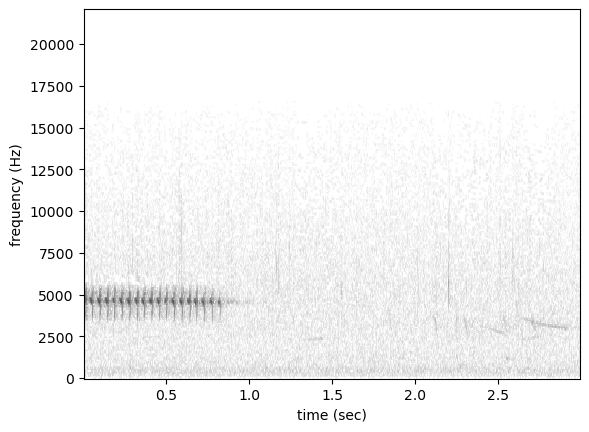

added confidence tag 5 to the dataframe.
confidence_cat
0     41658
5       331
2        85
3        60
1        13
6         3
4         1
33        1
Name: count, dtype: int64


/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_3331/699220391.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, 'confidence_cat'] = int(user_confidence)


In [2829]:
verified_full_train_df_with_preds = verify_samples(sample_train_df_with_preds, target=0.0, loss_sorted=True)

In [2830]:
verified_sample_train_df_with_preds.sample()

,,,target_presence,probability,loss,confidence_cat
file,start_time,end_time,,,,
../../data/raw/recordings/OSFL/recording-293160.mp3,61.5,64.5,0.0,0.110663,0.110663,0


# Save the validation work
This will save the training dataframe with a new column called 'confidence cat' which will show an extra layer of error checking, and allow us to re-label mislabelled samples. 


In [2831]:
verified_full_train_df_with_preds.to_pickle(data_path / "interim" / "train_set" / "verified_full_train_set.pkl")

In [2832]:
verified_sample_train_df_with_preds.confidence_cat.value_counts()

confidence_cat
0     41658
3      1437
2       494
5       331
1       319
4        77
6        50
33        1
Name: count, dtype: int64

# Clean the absence class too, then submit a report of the cleaning time and the categories after cleaning into a report. 
Cleaning 1000 samples takes about 4-5 hours. 

absence set confusers: 
- hermit thrush teer
- Western Wood-Pewee - Contopus sordidulus


presence set confusers: 
- say's phoebe (perhaps)
